Abundance as a funtion of time

In [ ]:
'''Libraries'''
#Data
import pandas as pd

#Plots
import matplotlib.pyplot as plt

#math
import numpy as np

#Usefull
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
%matplotlib widget

In [2]:
'''
Abundance as a funtion of time

this code loads 554 files, each file represents a value of t in times from t=2.3E-05 seconds to t=8.64E+06 seconds (100 days).
The path to the files is: Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps\snapsh_0001.dat' 
each path changes like snapsh_0001.dat,snapsh_0002.dat, ...snapsh_0554.

for each time there is a file with the following structure:
 time temp dens
 8.64000000000000000000000000E+06 1.00000000000000000000000000E-02 6.12595382759495E-19
 nin zin y x
 1 0 1.81077137723961E-19 1.81077137723961E-19
 0 1 2. 16780459396517E-09 2.16780459396517E-09
 1 1 1 1 9.43321881521884E-11 1.88664376304377E-10
 2 1 1 2.3748750996969422E-12 7.12462529908266E-12
 1 2 5.10414497594859E-14 1.53124349278458E-13
 2 2 2 2 3.41978236767250E-04 1.36791294706900E-03

nin is the number of neutrons, zin is the number of protons, y is number fraction and x is the mass fraction. 

We create Xi_ts, it is a list where each element corresponds to a 4-column matrix (nin,zin,y,x) and the index of the element corresponds to a certain value of t
The list ts is a list where ts[i] is the time value of file i e.j ts[0]=2.3E-5

'''
Xi_ts=[]
ts=[]
for i in tqdm(range(1,555)):
    datos=pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=3, delim_whitespace=True, names=['nin', 'zin', 'y', 'x'],dtype={'nin':int,'zin':int,'y':float,'x':float})
    Xi_ts.append(datos)
    df = pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=1, nrows=1, delim_whitespace=True, header=None)
    ts.append(df[0][0])
Xi_ts=np.array(Xi_ts)

  0%|          | 0/554 [00:00<?, ?it/s]

In [3]:
'''Lineal interpolation

In this part we create a new list Xi_t_i where each element represents a list of (x) at a certain time between 1 second and
100 days in 10000 steps (Xi_ts only had 554 steps, now Xi_t_i will have 10000 steps. The values will be fill using a interpolation).
 
'''
t = np.exp(np.linspace(0, 15.971913140, 10000))
Xi_t_i= np.empty((len(t), Xi_ts.shape[1]))
for i in tqdm(range(Xi_ts.shape[1])):
    spline_interp = interp1d(ts, Xi_ts[:,i,3], kind='linear')
    Xi_t_i[:, i] = spline_interp(t)

  0%|          | 0/6757 [00:00<?, ?it/s]

In [4]:
'''

This function returns the index i associated with both the list Xi_t_i[t] corresponding to the nucleus (n,z)

'''

columna_z=Xi_ts[0][:,1]
columna_n=Xi_ts[0][:,0]
def find_i_n_z(n,z):
    
    idx_start = np.searchsorted(columna_z, z, side='left')
    idx_end = np.searchsorted( columna_z, z, side='right')
    if idx_end>idx_start:
        j=np.searchsorted(columna_n[idx_start:idx_end],n)+idx_start
        if columna_n[j]==n and columna_z[j]==z:
            return j
        else:
            return 'no hay'
    else:
        return 'no hay'
    
'''

This function returns the abundance as a function of time of a nucleus (n,z).

'''
def Xi_t(n,z):
    
    h=find_i_n_z(n,z)
    if h!='no hay':
        return Xi_t_i[:,h]
    elif h=='no hay':
        return np.zeros(10000)

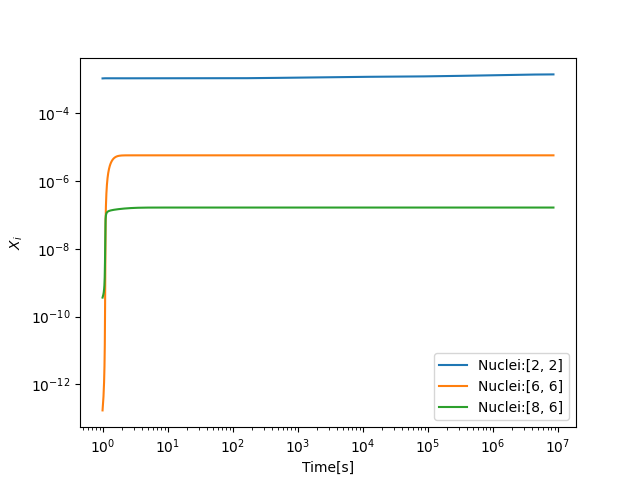

In [5]:
'''
this funtion plots abundance of nuclei

nucleis should be a list for example:[[2,2],[6,6],[8,6]]
this will be for alpha [2,2], 12C [6,6], 14C [8,6]

'''

def graph_abundance_nuclei(nulceis:list):
    plt.figure()
    for nu in nulceis:
        plt.plot(t,Xi_t(nu[0],nu[1]),label=f'Nuclei:{nu}')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Time[s]')
    plt.ylabel(r'$X_i$')

graph_abundance_nuclei([[2,2],[6,6],[8,6]])

In [6]:
'''Find relevant nuclei'''
H=np.searchsorted(t/(60*60*24),[1,100]) #chose range of interest
peaks=np.zeros(len(Xi_t_i[0]))
for i in range(len(Xi_t_i[0])):
    peaks[i]=max(Xi_t_i[H[0]:H[1],i])

relevant=(-peaks).argsort()


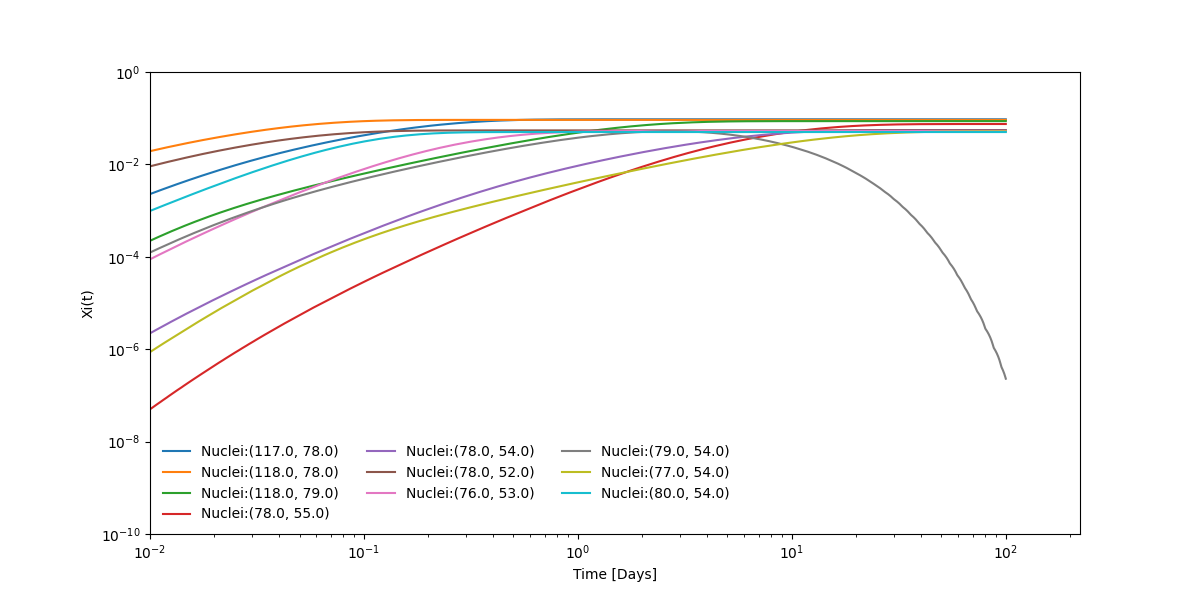

In [ ]:
'''
This funtion graph Xi of the top most relevant nuclei (You can chose top 5, 10, 20 etc...)
'''
def graph_important(top:int):
    plt.figure(figsize=(12,6))
   
    for i in range(top):
        plt.plot(t/(60*60*24),Xi_t_i[:,[relevant[i]]],label=f'Nuclei:{Xi_ts[0,relevant[i],0],Xi_ts[0,relevant[i],1]}')
    plt.ylabel(r'Xi(t)')
    plt.xlabel('Time [Days]')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(ncol=3,frameon=False)
    plt.ylim((10**-10,1))
    plt.xlim(left=0.01)
graph_important(10)
